## Important

### Make sure you have the Public transport data called `Public Transport Victoria` from the [Google Drive](https://drive.google.com/drive/folders/1JzqWIVPAHOvMeD0X1u3RefYBSj1PehZ0?usp=sharing) and save it in the `data/map/` directory. Also download the `VIC Localities Shape File` from the [Google Drive](https://drive.google.com/drive/folders/1JzqWIVPAHOvMeD0X1u3RefYBSj1PehZ0?usp=sharing) and save that in the `data/map/` directory.

---

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium
import os

#### Load public transport & Victorian suburbs shape files

In [2]:
# Load the area shapefile and line shapefile for public transports
pt_area_gdf = gpd.read_file('../../data/map/Public Transport Victoria/gis_osm_transport_a_free_1.shp')
pt_line_gdf = gpd.read_file('../../data/map/Public Transport Victoria/gis_osm_transport_free_1.shp')
pt_gdf = pd.concat([pt_area_gdf, pt_line_gdf], ignore_index=True)

# Load Victoria suburbs shapefile for filtering (since the public transports are for all Australia)
vic_suburbs_gdf = gpd.read_file('../../data/map/VIC Localities Shape File/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)

# Filter public transport stops that fall within Victoria
filtered_pt_gdf = gpd.sjoin(pt_gdf.to_crs(epsg=4326), vic_suburbs_gdf, how='inner', predicate='intersects')


In [3]:
# Filter train stations and tram stops
train_stops_gdf = filtered_pt_gdf[filtered_pt_gdf['fclass'].isin(['railway_station', 'railway_halt'])]
tram_stops_gdf = filtered_pt_gdf[filtered_pt_gdf['fclass'] == 'tram_stop']

In [ ]:
plot_directory = '../../plots/public_transport_visualisations'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

#### Map the train stations

In [5]:
# Create a map for Train Stops
train_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)  # Centered on Melbourne

for idx, row in train_stops_gdf.iterrows():
    # Check if the geometry is a point or polygon and extract centroid if necessary
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],  # coordinates from the centroid
        popup=f"Train Stop: {row['name']}",  # name of the station to make it interactive
        icon=folium.Icon(color='blue', icon='train')
    ).add_to(train_map)

# Save the Train Stops map
train_map.save('../../plots/public_transport_visualisations/train_stops_map.html')

#### Map the tram stops

In [6]:
# Create a map for Tram Stops
tram_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)  # Zoom in closer for trams / not as spread out as trains

for idx, row in tram_stops_gdf.iterrows():
    # Check if the geometry is a point or polygon and extract centroid if necessary
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],  # coordinates from the centroid
        popup=f"Tram Stop: {row['name']}",  # name of the stop to make it interactive
        icon=folium.Icon(color='green', icon='info-sign') 
    ).add_to(tram_map)

# Save the Tram Stops map
tram_map.save('../../plots/public_transport_visualisations/tram_stops_map.html')

#### Combined map for trains and trams

In [7]:
# Create a combined map for both Train and Tram Stops
combined_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

for idx, row in train_stops_gdf.iterrows():
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],
        popup=f"Train Stop: {row['name']}",
        icon=folium.Icon(color='blue', icon='train')
    ).add_to(combined_map)

for idx, row in tram_stops_gdf.iterrows():
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],
        popup=f"Tram Stop: {row['name']}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(combined_map)

# Save the combined map with both train and tram stops
combined_map.save('../../plots/public_transport_visualisations/combined_train_tram_stops_map.html')


#### Checking which suburbs have the most accessibility to public transport

In [14]:
# Combine train and tram stops into one GeoDataFrame 
train_tram_stops_gdf = pd.concat([train_stops_gdf, tram_stops_gdf])

# spatial join to associate the filtered train/tram stops with suburbs
pt_with_suburbs_gdf = gpd.sjoin(
    train_tram_stops_gdf, 
    vic_suburbs_gdf[['LOCALITY', 'geometry']], 
    how='inner', 
    predicate='intersects', 
    lsuffix='pt', rsuffix='suburb' 
)

# Group by suburb using the correct column name 'LOCALITY_suburb'
suburb_accessibility = pt_with_suburbs_gdf.groupby('LOCALITY_suburb').size().reset_index(name='num_stops')


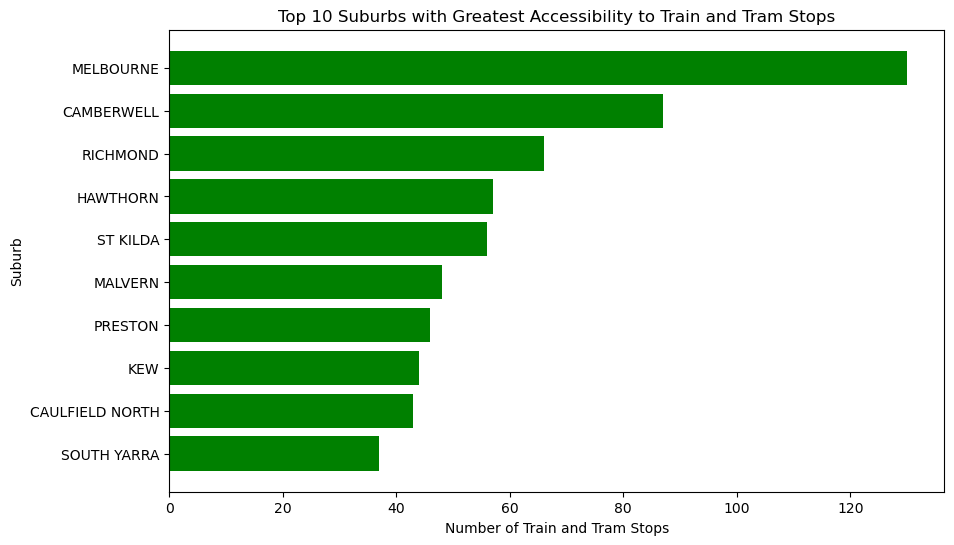

In [19]:
most_accessible_suburbs = suburb_accessibility.sort_values(by='num_stops', ascending=False).head(10)  # Top 10 most accessible
# Plot histogram for most accessible suburbs
plt.figure(figsize=(10, 6))
plt.barh(most_accessible_suburbs['LOCALITY_suburb'], most_accessible_suburbs['num_stops'], color='green')
plt.xlabel('Number of Train and Tram Stops')
plt.ylabel('Suburb')
plt.title('Top 10 Suburbs with Greatest Accessibility to Train and Tram Stops')
plt.gca().invert_yaxis() 
plt.savefig('../../plots/public_transport_visualisations/most_accessible_public_transport.png', bbox_inches = 'tight')
plt.show()